In [1]:
exclude_models = [] # list of 4 digit hexa string or empty list

In [2]:
# Loading models

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import json
import pandas as pd
from scipy.signal import savgol_filter
import yaml
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import Image, display

# Getting list of model's archive path
source = f"data/model_comparison/model_list.yml"
with open(source) as f:
    archives = yaml.safe_load(f)

# Loading models
all_models = {}
print("Loading models:")
for model_number, archive in archives.items():

    try:
        details = json.load(open(f'{archive}/details.json'))
        model_id = details["model_id"]

        if model_id in exclude_models:
            continue

        history = np.load(f'{archive}/history.npz', allow_pickle=True)
        content = np.load(f'{archive}/predictions.npz', allow_pickle=True)
        predictions = content["predictions"].item()
        expectations = content["expectations"].item()

        print(f" - {model_number}: {archive}/details.json")
        print(f"      History keys: {', '.join(list(history.keys()))}")
        
        all_models[model_id] = {
            "archive": archive,
            "details": details,
            "history": history,
            "predictions": predictions,
            "expectations": expectations
        }
    except Exception as e:
        print("Could not load model", model_number)
        print(e)

Loading models:
 - 0001: ./archives/2023-04-21_47f3775/2/details.json
      History keys: loss, Plummer_max_loss, Plummer_radius_loss, Plummer_slope_loss, Plummer_max_MAE, Plummer_radius_MAE, Plummer_slope_MAE, val_loss, val_Plummer_max_loss, val_Plummer_radius_loss, val_Plummer_slope_loss, val_Plummer_max_MAE, val_Plummer_radius_MAE, val_Plummer_slope_MAE
 - 0002: ./archives/2023-04-21_47f3775/3/details.json
      History keys: loss, Plummer_max_loss, Plummer_radius_loss, Plummer_slope_loss, Plummer_max_MAE, Plummer_radius_MAE, Plummer_slope_MAE, val_loss, val_Plummer_max_loss, val_Plummer_radius_loss, val_Plummer_slope_loss, val_Plummer_max_MAE, val_Plummer_radius_MAE, val_Plummer_slope_MAE
 - 0003: ./archives/2023-04-21_47f3775/4/details.json
      History keys: loss, Plummer_max_loss, Plummer_radius_loss, Plummer_slope_loss, Plummer_max_MAE, Plummer_radius_MAE, Plummer_slope_MAE, val_loss, val_Plummer_max_loss, val_Plummer_radius_loss, val_Plummer_slope_loss, val_Plummer_max_MAE, v

In [3]:
# Selecting model to compare

models = {}
def update_model_list_select(*args):
    global models
    models = {}
    for key in model_list_select.value:
        models[key] = all_models[key]

model_list_select = widgets.SelectMultiple(
    options=list(all_models.keys()),
    value=list(all_models.keys()),
    description='Models',
    disabled=False
)

model_list_select.observe(update_model_list_select)
display(model_list_select)
update_model_list_select()

SelectMultiple(description='Models', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), options…

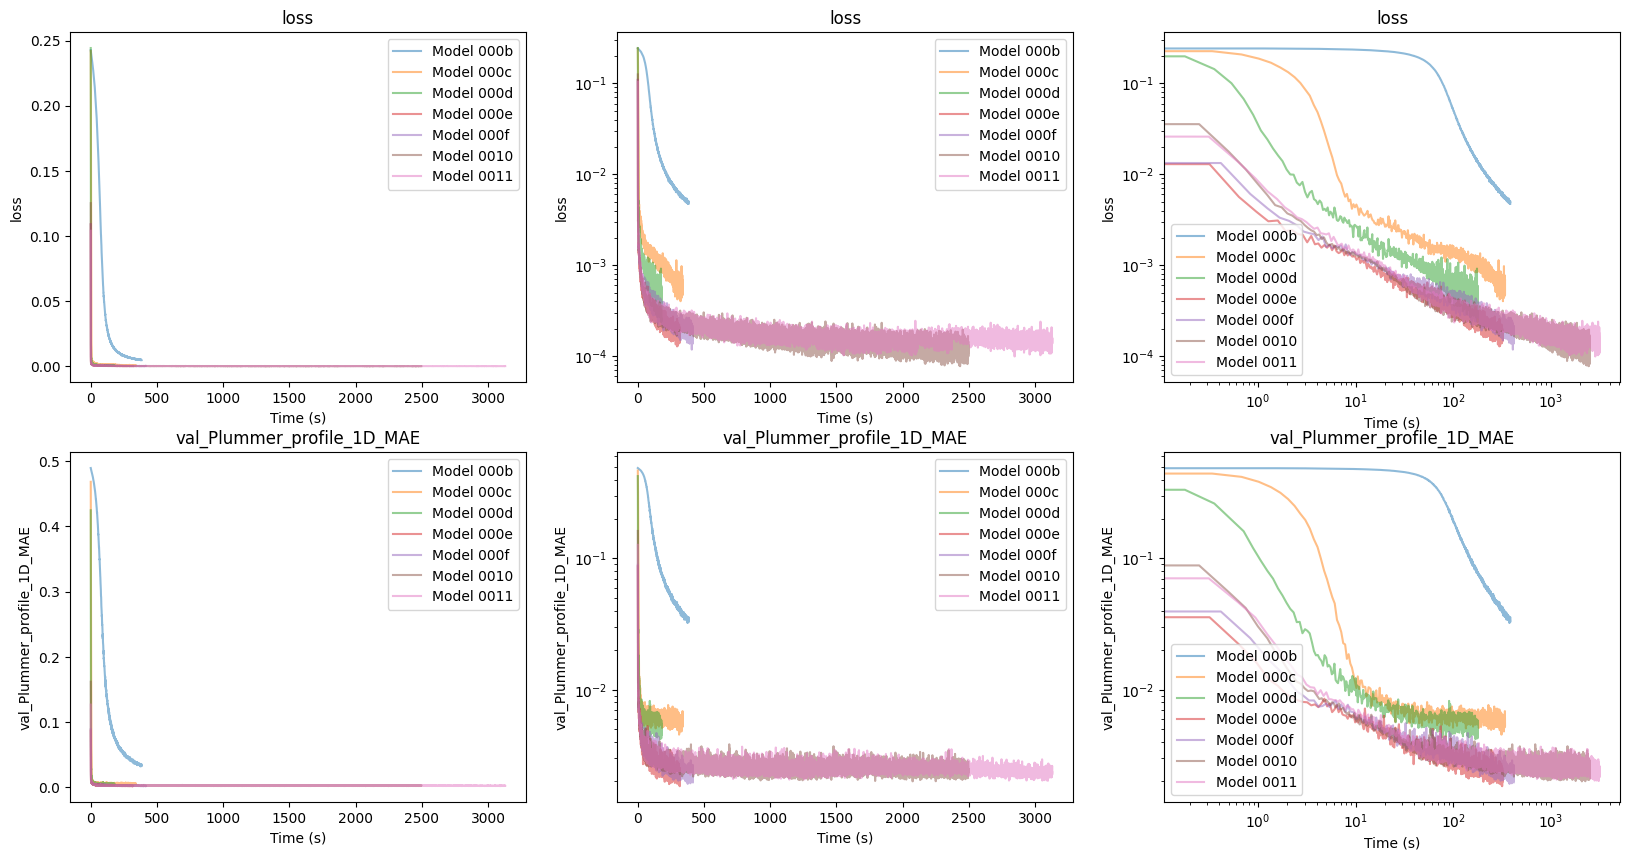

In [8]:
# Plot training evolution

# Looking at how many different val metrics are available
nb_metrics = 1
seen_metrics = ["loss"]
for model_id, model in models.items():
    for key in model["history"].keys():
        if key.startswith("val_") and not key.endswith("loss") and key not in seen_metrics:
            seen_metrics.append(key)
            nb_metrics += 1

fig, axs = plt.subplots(nb_metrics, 3, figsize=(20, 5*nb_metrics))

for model_id, model in models.items():

    history = model["history"]
    time_range = np.linspace(0, model["details"]["training_time"], model["details"]["epochs"], endpoint=True)

    # Printing loss
    for i, key in enumerate(seen_metrics):
        if key in history:
            for ax in axs[i]:
                curve = history[key]
                ax.plot(time_range, curve, alpha=0.5, label=f"Model {model_id}")


for i, row in enumerate(axs):
    for ax in row:
        ax.set_title(seen_metrics[i])
        ax.set_ylabel(seen_metrics[i])
        ax.set_xlabel('Time (s)')
        ax.legend()
    row[1].set_yscale('log')
    row[2].set_xscale('log')
    row[2].set_yscale('log')

plt.show()

In [5]:
# Violin plot def

def violin_plot(output, model_list, limits):
    plt.figure(figsize=(20, 10))

    labels = []
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    i = 0
    for key in model_list:
        model = models[key]

        if output not in model["predictions"]:
            print(f"Model {key} has no {output} output. Ingoring it.")
            continue

        expectations = np.array(model["expectations"][output])  
        predictions = np.array(model["predictions"][output])

        expectations = expectations.flatten()
        dim_order = list(range(len(predictions.shape)))
        dim_order.pop(1)
        dim_order.append(1)
        predictions = np.transpose(predictions, dim_order)
        N = predictions.shape[-1]
        S = predictions.size
        predictions = predictions.reshape((S//N,N)).T
        
        vmin = float(limits[0])
        vmax = float(limits[1])
        eps = (float(limits[1]) - float(limits[0])) * 0.01

        mask = (expectations + eps >= vmin) & (expectations - eps <= vmax)
        expectations = expectations[mask]
        predictions = predictions[:,mask]        

        emin = np.min(expectations)
        emax = np.max(expectations)

        plt.plot([emin,emax],[emin,emax], c="black", linewidth=1)

        violin_parts = plt.violinplot(
            dataset=predictions[:,:],
            positions=expectations[:], 
            widths=(np.max(expectations)-np.min(expectations))*0.05, showmeans=True, showextrema=False
        )

        add_label(violin_parts, f"Model {key}")
 
    plt.title(f'Model predictions on {output}')
    plt.ylabel('Predictions')
    plt.xlabel('Expected')
    plt.ticklabel_format(axis="both", style='sci', scilimits=(0,0))
    plt.grid()
    plt.legend(*zip(*labels), loc=2)
    plt.show()

SelectMultiple(description='Plot models', index=(5, 6), options=('000b', '000c', '000d', '000e', '000f', '0010…

Dropdown(description='Output: ', options=('Plummer_profile_1D',), value='Plummer_profile_1D')

SelectionRangeSlider(description='Range', index=(32584, 32866), layout=Layout(width='100%'), options=('1.87e-1…

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

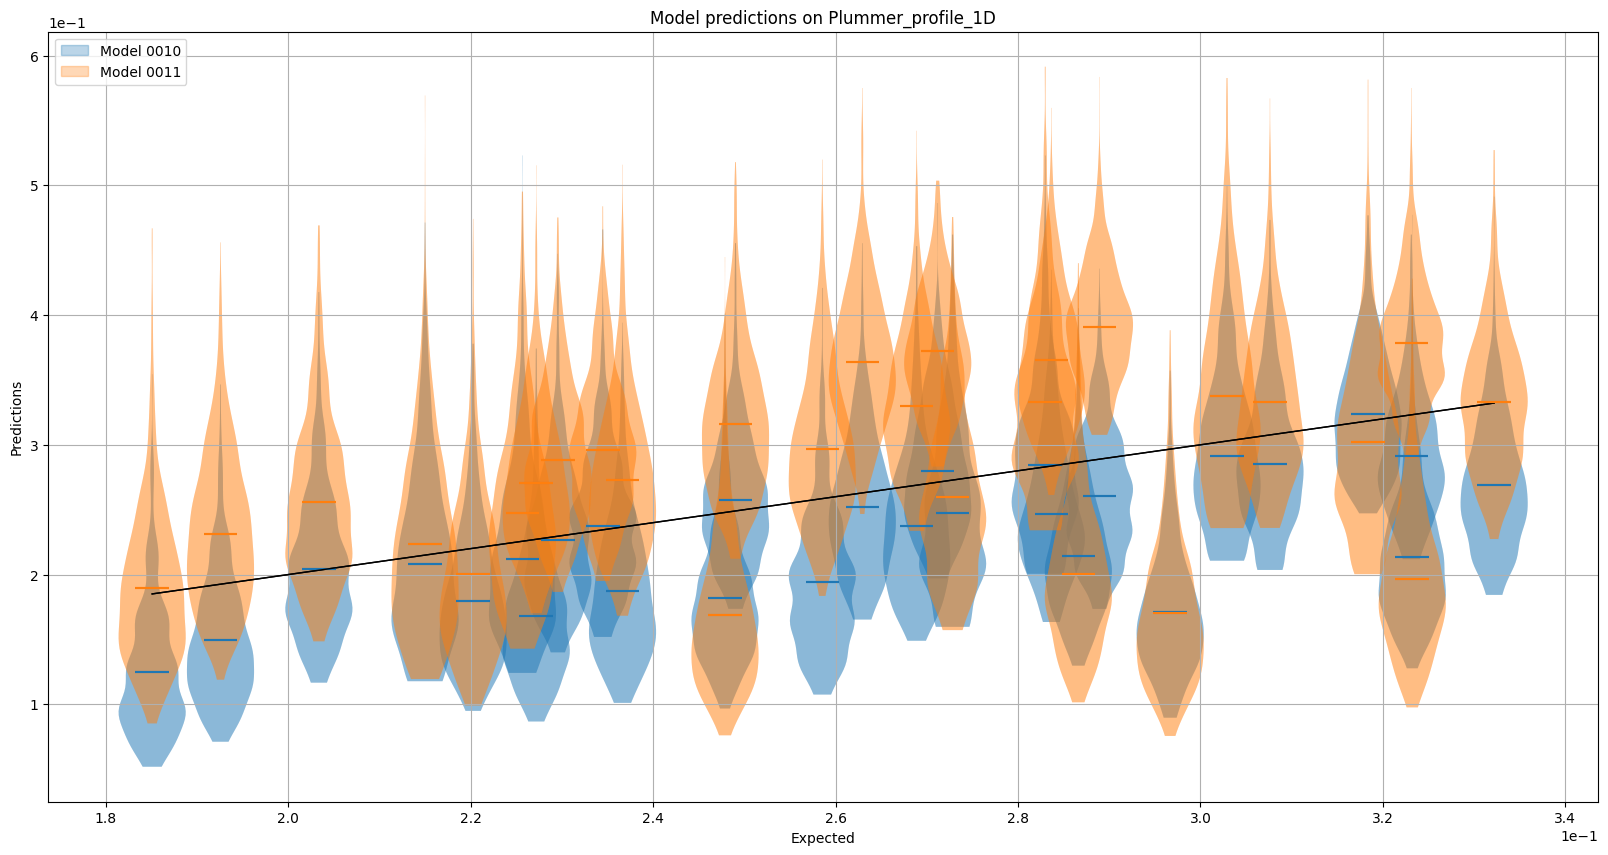

In [6]:
# Show violin plot

# Second model filter------------------------------------------------------------------------

plot_model_list_select = widgets.SelectMultiple(
    options=list(models.keys()),
    value=list(models.keys()),
    description='Plot models',
    disabled=False
)

# Select output among the possible  ---------------------------------------------------------

def get_output_dropdown():
    outputs = []
    for key in plot_model_list_select.value:
        for expectation in models[key]["expectations"]:
            if expectation not in outputs:
                outputs.append(expectation)
    return Dropdown(options=outputs, value=outputs[0], description="Output: "), outputs
output_dropdown, outputs = get_output_dropdown()

# Select range of expectations in the output value's space ----------------------------------

def get_expectation_slider():
    possible_expectations = np.array([])
    for model in models.values():
        if output_dropdown.value not in model["expectations"]:
            continue
        possible_expectations = np.concatenate((
            possible_expectations,
            model["expectations"][output_dropdown.value].flatten()
        ))
    possible_expectations = list(map(lambda x: f"{x:.2e}", np.sort(possible_expectations).tolist()))
    return widgets.SelectionRangeSlider(
        options=possible_expectations,
        index=(0, len(possible_expectations)-1),
        description='Range',
        disabled=False,
        width='100%',
        layout=Layout(width='100%')  
    )
expectation_slider = get_expectation_slider()

# Plot button ------------------------------------------------------------------------------

plot_button = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Update GUI on action ---------------------------------------------------------------------

def update_gui(*args):
    clear_output()
    display(plot_model_list_select)
    display(output_dropdown)
    display(expectation_slider)
    display(plot_button)

def update_expectation_slider(*args):
    global expectation_slider
    expectation_slider = get_expectation_slider()
    update_gui()

def update_output_dropdown(*args):
    global expectation_slider, output_dropdown, outputs
    new_output_dropdown, new_outputs = get_output_dropdown()
    if outputs != new_outputs:
        old_select = output_dropdown.value
        output_dropdown, outputs = new_output_dropdown, new_outputs
        if old_select in outputs:
            output_dropdown.value = old_select
        else:
            expectation_slider = get_expectation_slider()
        update_gui()

def update_violin_plot(*args):
    update_gui()
    violin_plot(output_dropdown.value, plot_model_list_select.value, expectation_slider.value)

plot_model_list_select.observe(update_output_dropdown)
output_dropdown.observe(update_expectation_slider)
plot_button.on_click(update_violin_plot)
update_gui()


Dropdown(description='Model ID: ', index=6, options=('0001', '0002', '0003', '0004', '0005', '0006', '0007', '…

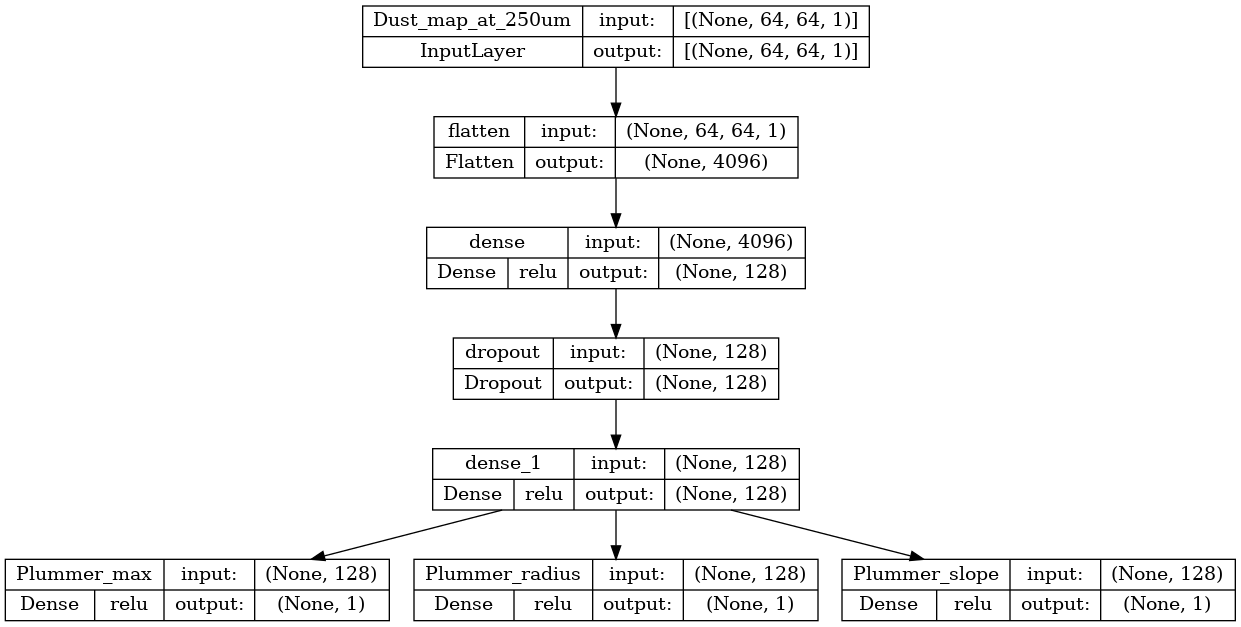

Total params: 541,315
Trainable params: 541,315
Non-trainable params: 0
__________________________________________________________________________________________________

Optimizer: RMSprop
Loss: mean_squared_error
Metrics:
 - MAE

Epochs: 10000
Batch size: 100

Training time: 52m 19.05s
Score:
 - 7.77e-03
 - 4.52e-03
 - 1.88e-03
 - 1.36e-03
 - 5.57e-02
 - 3.46e-02
 - 2.57e-02

Validation fraction: 20 %
Test fraction: 10 %

Path: ./archives/2023-04-22_47f3775/6



In [7]:
# Select model and view details

def print_model_details(id):

    model = all_models[id]
    archive = model["archive"]
    details = model["details"]

    display(Image(filename=f'{archive}/model.png'))
    print("\n".join(details['summary'][-4:]))

    print("")
    print("Optimizer:", details['optimizer'])
    if isinstance(details['loss'], list):
        print("Loss:\n -", "\n - ".join(details['loss']))
    else:
        print("Loss:", details['loss'])
    print("Metrics:\n -", "\n - ".join(details['metrics']))
    print("")
    print("Epochs:", details['epochs'])
    print("Batch size:", details['batch_size'])
    print("")
    print(f"Training time: {int(details['training_time']//60)}m {details['training_time']%60:.2f}s" )
    print("Score:\n -", "\n - ".join([f"{i:.2e}" for i in details['scores']]))
    print("")
    # print("Dataset size:", details['dataset_size'])
    print("Validation fraction:", int(details['val_frac'] * 100), "%")
    print("Test fraction:", int(details['test_frac'] * 100), "%")
    print("")
    print("Path:", archive)
    print("")
    if "inputs" in details:
        print("Inputs:\n -", "\n - ".join(details['inputs']))
    if "outputs" in details:
        print("Outputs:\n -", "\n - ".join(details['outputs']))

options = []
for model in all_models.values():
    options.append(model["details"]["model_id"])

selected_model = options[0]

model_widget = Dropdown(options=options, value=options[0], description="Model ID: ")

# Define a function that updates the content of y based on what we select for x
def update_model_widget(*args):
    global selected_model
    clear_output()
    display(model_widget)
    print_model_details(model_widget.value)
    selected_model = all_models[model_widget.value]

model_widget.observe(update_model_widget)
update_model_widget()